In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import PIL
import cv2
import itertools
import numpy as np
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

2023-11-15 10:14:20.588995: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 10:14:20.601169: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 10:14:20.720306: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 10:14:20.721339: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 10:14:21.427605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
import pathlib
data_dir = pathlib.Path('/home/hduser/Desktop/augmented data/')
print(data_dir)

/home/hduser/Desktop/augmented data


/home/hduser/Desktop/augmented data/barbutellus/augmented_barbutellus_0_7377.jpg


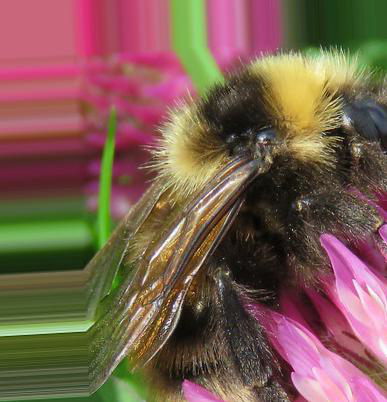

In [3]:
barbutellus = list(data_dir.glob('barbutellus/*'))
print(barbutellus[10])
PIL.Image.open(str(barbutellus[10]))

In [4]:
img_height, img_width = (224, 224)
batch_size = 32

In [5]:
train_batches = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2,
    subset='training', seed=8,
    #labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width), 
    batch_size=batch_size)

Found 6843 files belonging to 21 classes.
Using 5475 files for training.


2023-11-15 10:14:22.782041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: alecfei-linuxlaptop
2023-11-15 10:14:22.782059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: alecfei-linuxlaptop
2023-11-15 10:14:22.782177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-11-15 10:14:22.782201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  545.23.06  Release Build  (dvs-builder@U16-I3-C17-2-2)  Sun Oct 15 17:35:00 UTC 2023
GCC version:  gcc version 11.4.0 (Ubuntu 11.4.0-1ubuntu1~22.04) 
"


In [6]:
file_count = 0

for root, dirs, files in os.walk(data_dir):
    file_count += len(files)

print("Total number of files in the directory and its subdirectories:", file_count)

Total number of files in the directory and its subdirectories: 6843


In [7]:
validate_batches = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2,
    subset='validation', seed=8,
    label_mode='categorical',
    image_size=(img_height, img_width), 
    batch_size=batch_size)

Found 6843 files belonging to 21 classes.
Using 1368 files for validation.


In [8]:
class_names = train_batches.class_names
print(class_names)

['barbutellus', 'bohemicus', 'campestris', 'cryptarum', 'distinguendus', 'hortorum', 'hypnorum', 'jonellus', 'lapidarius', 'lucorum', 'magnus', 'monticola', 'muscorum', 'pascuorum', 'pratorum', 'ruderarius', 'rupestris', 'sylvarum', 'sylvestris', 'terrestris', 'vestalis']


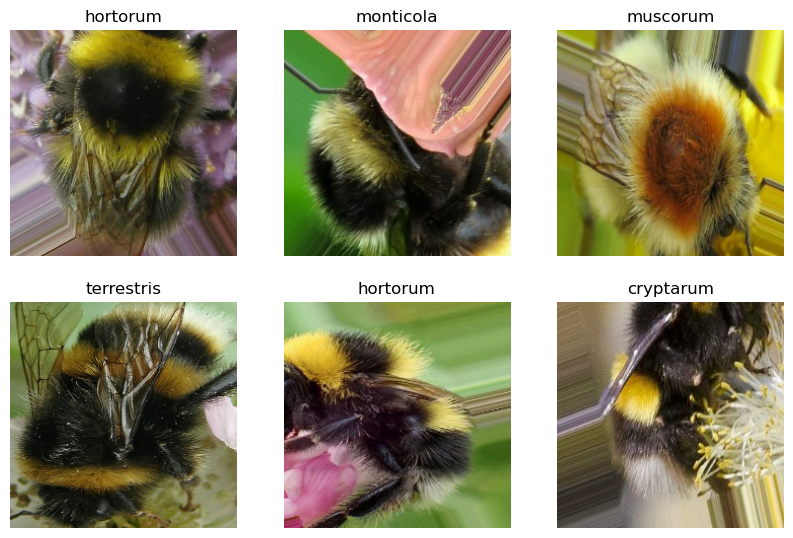

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_batches.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = labels[i].numpy().argmax()
        plt.title(class_names[label_index])
        plt.axis("off")

In [10]:
test_dir = pathlib.Path('/home/hduser/Desktop/testing dataset/')
print(test_dir)

/home/hduser/Desktop/testing dataset


## 1. ResNet50

In [11]:
resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in resnet50.layers:
        layer.trainable=False

In [12]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [13]:
model_resnet50 = Sequential()

model_resnet50.add(resnet50)
model_resnet50.add(Flatten())
model_resnet50.add(Dense(512, activation='relu'))
model_resnet50.add(Dropout(0.5))
#model_resnet50.add(Dense(256, activation='relu'))
#model_resnet50.add(Dropout(0.5))
#model_resnet50.add(Dense(128, activation='relu'))
#model_resnet50.add(Dropout(0.5))
#model_resnet50.add(Dense(64, activation='relu'))
#model_resnet50.add(Dense(32, activation='relu'))
model_resnet50.add(Dense(21, activation='softmax'))

In [14]:
model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 21)                10773     
                                                                 
Total params: 24647573 (94.02 MB)
Trainable params: 1059861 (4.04 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [15]:
model_resnet50.compile(optimizer=Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [16]:
epoch_resnet50 = 10

result_resnet50 = model_resnet50.fit(train_batches,
                                     validation_data=validate_batches,
                                     epochs=epoch_resnet50,
                                     verbose=2)

Epoch 1/10
172/172 - 116s - loss: 2.7648 - accuracy: 0.1837 - val_loss: 2.1098 - val_accuracy: 0.3743 - 116s/epoch - 677ms/step
Epoch 2/10
172/172 - 113s - loss: 2.0486 - accuracy: 0.3525 - val_loss: 1.6677 - val_accuracy: 0.5219 - 113s/epoch - 659ms/step
Epoch 3/10
172/172 - 112s - loss: 1.7246 - accuracy: 0.4532 - val_loss: 1.4542 - val_accuracy: 0.5541 - 112s/epoch - 654ms/step
Epoch 4/10
172/172 - 112s - loss: 1.5099 - accuracy: 0.5156 - val_loss: 1.3071 - val_accuracy: 0.6045 - 112s/epoch - 650ms/step
Epoch 5/10
172/172 - 112s - loss: 1.3511 - accuracy: 0.5620 - val_loss: 1.1449 - val_accuracy: 0.6630 - 112s/epoch - 651ms/step
Epoch 6/10
172/172 - 112s - loss: 1.2362 - accuracy: 0.5934 - val_loss: 1.0023 - val_accuracy: 0.6966 - 112s/epoch - 653ms/step
Epoch 7/10
172/172 - 113s - loss: 1.1318 - accuracy: 0.6281 - val_loss: 0.9446 - val_accuracy: 0.7346 - 113s/epoch - 659ms/step
Epoch 8/10
172/172 - 114s - loss: 1.0340 - accuracy: 0.6504 - val_loss: 0.9402 - val_accuracy: 0.7208 - 

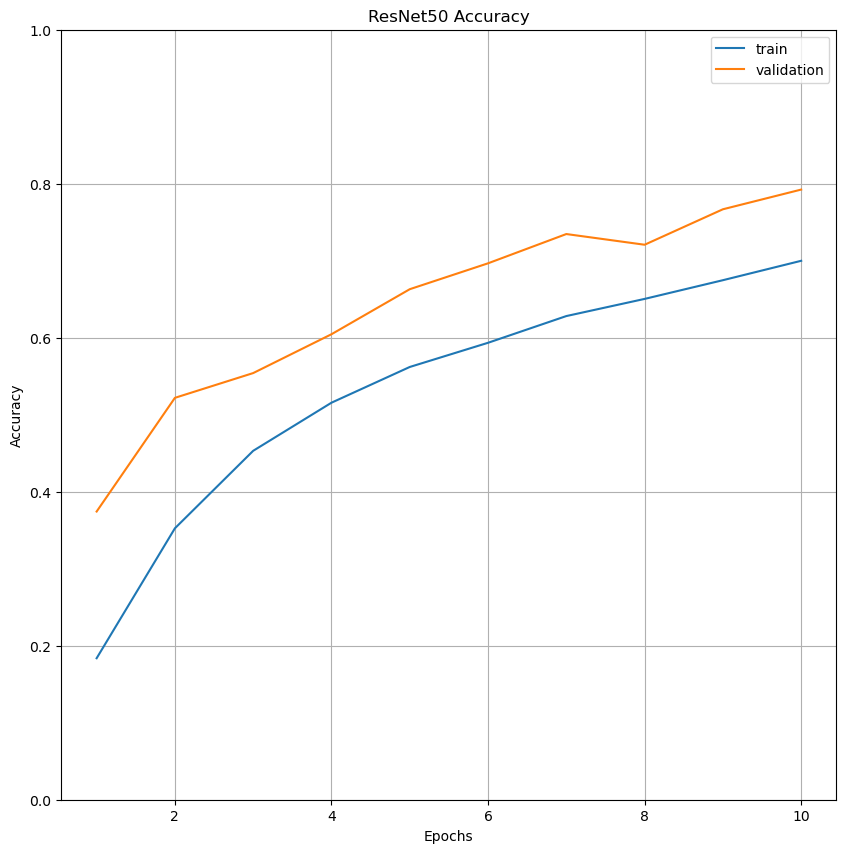

In [17]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_resnet50 + 1)
plt.plot(epochs_range, result_resnet50.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_resnet50.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('ResNet50 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

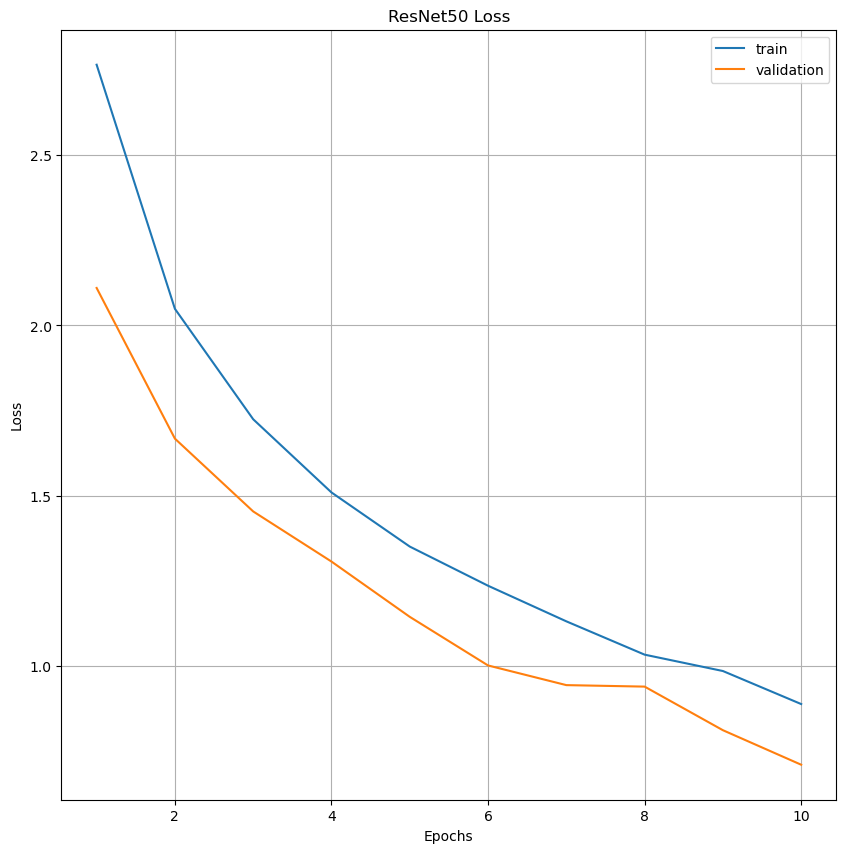

In [18]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_resnet50 + 1)
plt.plot(epochs_range, result_resnet50.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_resnet50.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('ResNet50 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

<br></br>
<font size="6">**Testing**</font>
<br></br>

In [19]:
barbutellus_test = list(test_dir.glob('bombus barbutellus/*'))
len(barbutellus_test)

18

/home/hduser/Desktop/testing dataset/bombus barbutellus/bombus barbutellus male 15.jpg


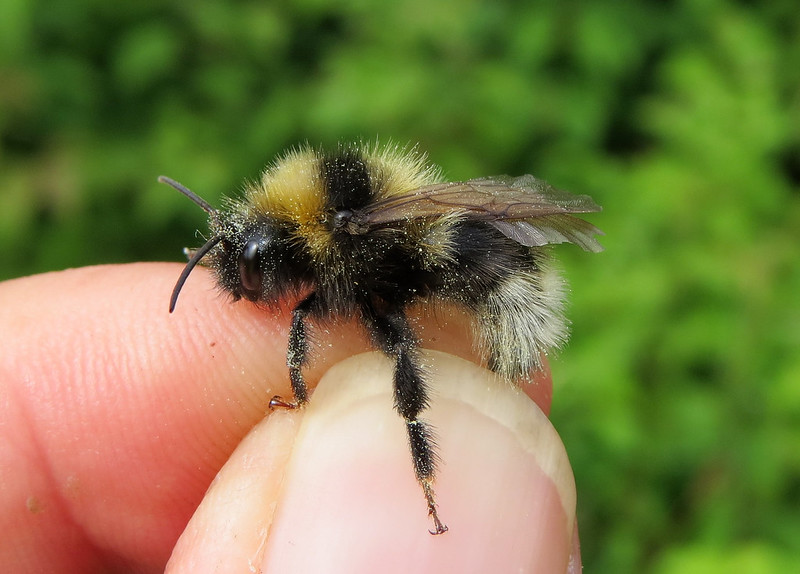

In [20]:
print(barbutellus_test[8])
PIL.Image.open(str(barbutellus_test[8]))

In [21]:
test_image=cv2.imread(str(barbutellus_test[8]))
test_image_resized=cv2.resize(test_image, (img_height, img_width))
test_image=np.expand_dims(test_image_resized, axis=0)

image_pil = PIL.Image.fromarray(test_image[0])
image_pil.show()

In [22]:
test_image_pred=model_resnet50.predict(test_image)

1/1 [==============================] - 1s 531ms/step


In [23]:
test_image_class=class_names[np.argmax(test_image_pred)]

print("The predicted class is: ", test_image_class)

The predicted class is:  bohemicus


In [24]:
terrestris_test = list(test_dir.glob('bombus terrestris/*'))
len(terrestris_test)

166

/home/hduser/Desktop/testing dataset/bombus terrestris/bombus terrestris queen 15 (melanic).jpg


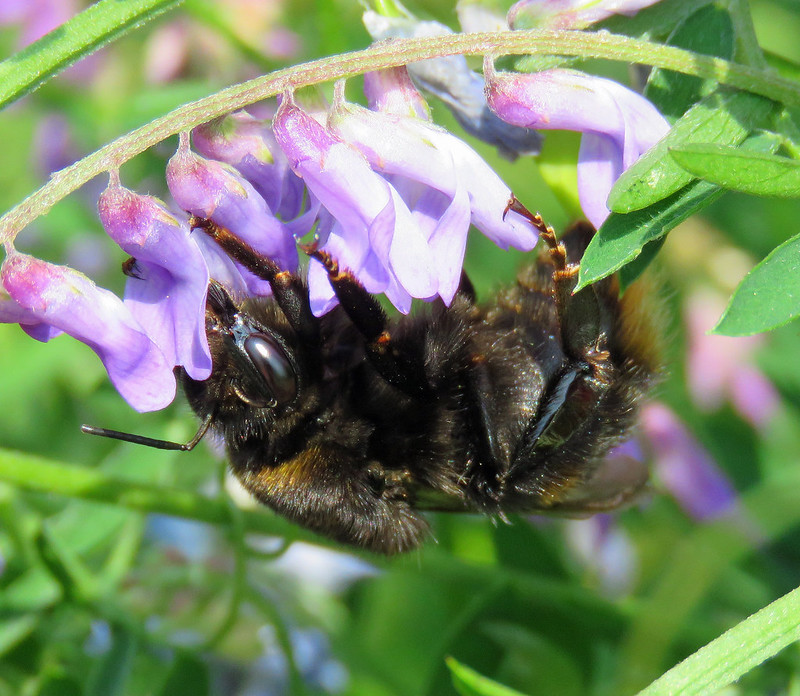

In [25]:
print(terrestris_test[9])
PIL.Image.open(str(terrestris_test[9]))

In [26]:
test_image=cv2.imread(str(terrestris_test[9]))
test_image_resized=cv2.resize(test_image, (img_height, img_width))
test_image=np.expand_dims(test_image_resized, axis=0)

image_pil = PIL.Image.fromarray(test_image[0])
image_pil.show()

In [27]:
test_image_pred=model_resnet50.predict(test_image)

1/1 [==============================] - 0s 44ms/step


In [28]:
test_image_class=class_names[np.argmax(test_image_pred)]

print("The predicted class is: ", test_image_class)

The predicted class is:  bohemicus


## 2. VGG19

In [29]:
vgg19 = tf.keras.applications.VGG19(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in vgg19.layers:
        layer.trainable=False

In [30]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
model_vgg19 = Sequential()

model_vgg19.add(vgg19)
model_vgg19.add(Flatten())
model_vgg19.add(Dense(512, activation='relu'))
model_vgg19.add(Dropout(0.5))
#model_vgg19.add(Dense(256, activation='relu'))
#model_vgg19.add(Dropout(0.5))
#model_vgg19.add(Dense(128, activation='relu'))
#model_vgg19.add(Dropout(0.5))
#model_vgg19.add(Dense(64, activation='relu'))
#model_vgg19.add(Dense(32, activation='relu'))
model_vgg19.add(Dense(21, activation='softmax'))

In [32]:
model_vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 21)                10773     
                                                                 
Total params: 20297813 (77.43 MB)
Trainable params: 273429 (1.04 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [33]:
model_vgg19.compile(optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [34]:
epoch_vgg19 = 10

result_vgg19 = model_vgg19.fit(train_batches,
                               validation_data=validate_batches,
                               epochs=epoch_vgg19,
                               verbose=2)

Epoch 1/10
172/172 - 380s - loss: 3.8041 - accuracy: 0.1226 - val_loss: 2.5201 - val_accuracy: 0.2661 - 380s/epoch - 2s/step
Epoch 2/10
172/172 - 382s - loss: 2.4414 - accuracy: 0.2588 - val_loss: 2.0382 - val_accuracy: 0.3969 - 382s/epoch - 2s/step
Epoch 3/10
172/172 - 380s - loss: 2.0698 - accuracy: 0.3529 - val_loss: 1.7638 - val_accuracy: 0.4613 - 380s/epoch - 2s/step
Epoch 4/10
172/172 - 380s - loss: 1.8380 - accuracy: 0.4153 - val_loss: 1.6070 - val_accuracy: 0.5000 - 380s/epoch - 2s/step
Epoch 5/10
172/172 - 381s - loss: 1.6544 - accuracy: 0.4740 - val_loss: 1.4856 - val_accuracy: 0.5300 - 381s/epoch - 2s/step
Epoch 6/10
172/172 - 381s - loss: 1.5204 - accuracy: 0.5074 - val_loss: 1.3352 - val_accuracy: 0.5841 - 381s/epoch - 2s/step
Epoch 7/10
172/172 - 380s - loss: 1.3776 - accuracy: 0.5549 - val_loss: 1.2940 - val_accuracy: 0.5855 - 380s/epoch - 2s/step
Epoch 8/10
172/172 - 379s - loss: 1.2629 - accuracy: 0.5931 - val_loss: 1.1518 - val_accuracy: 0.6389 - 379s/epoch - 2s/step


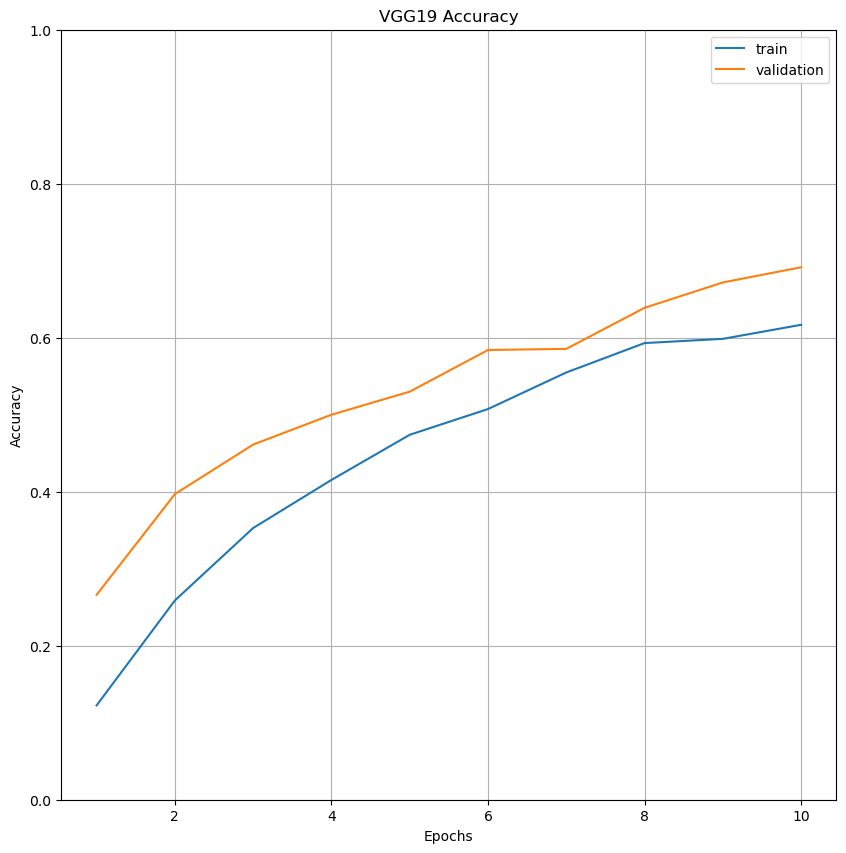

In [35]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_vgg19 + 1)
plt.plot(epochs_range, result_vgg19.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_vgg19.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('VGG19 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

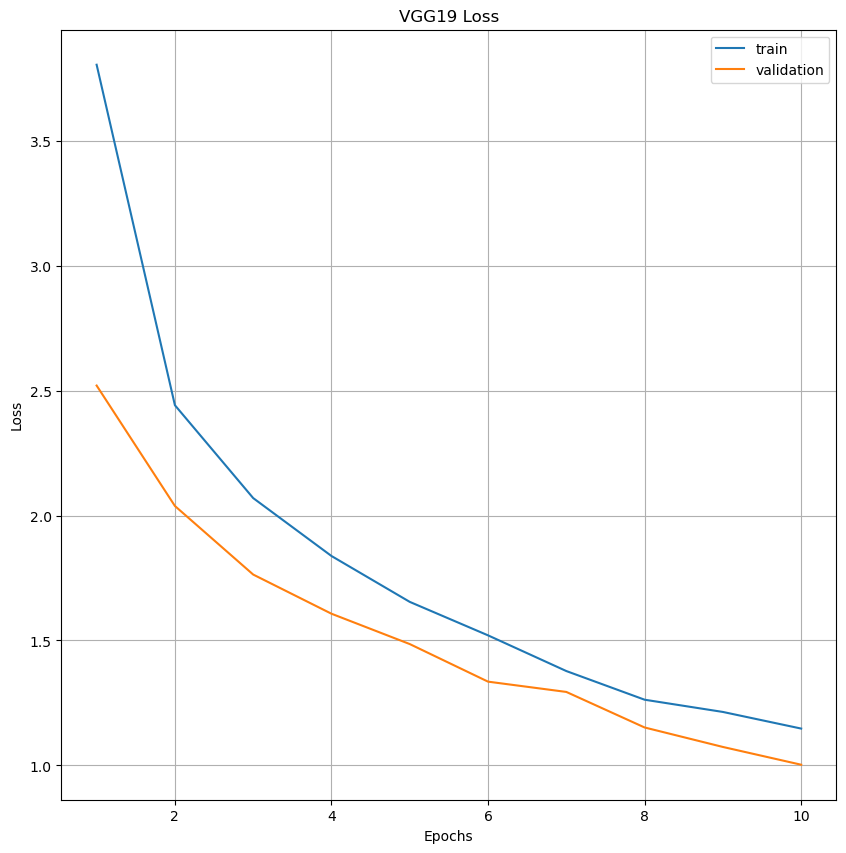

In [36]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_vgg19 + 1)
plt.plot(epochs_range, result_vgg19.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_vgg19.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('VGG19 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

<br></br>
<font size="6">**Testing**</font>
<br></br>

In [37]:
bohemicus_test = list(test_dir.glob('bombus bohemicus/*'))
len(bohemicus_test)

2

/home/hduser/Desktop/testing dataset/bombus bohemicus/bombus bohemicus male 9.jpg


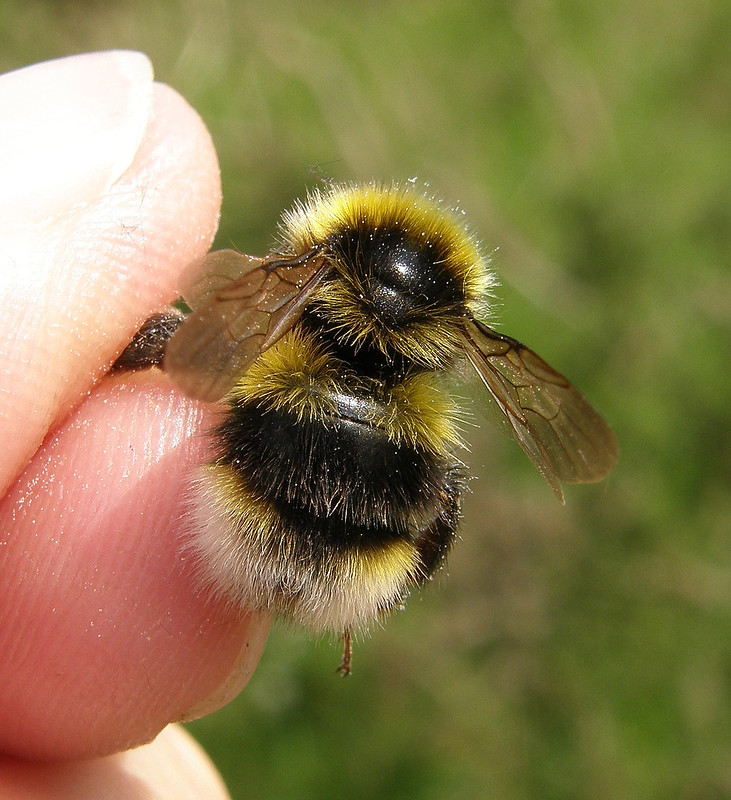

In [38]:
print(bohemicus_test[1])
PIL.Image.open(str(bohemicus_test[1]))

In [39]:
test_image=cv2.imread(str(bohemicus_test[1]))
test_image_resized=cv2.resize(test_image, (img_height, img_width))
test_image=np.expand_dims(test_image_resized, axis=0)

image_pil = PIL.Image.fromarray(test_image[0])
image_pil.show()

In [40]:
test_image_pred=model_vgg19.predict(test_image)

1/1 [==============================] - 0s 154ms/step


In [41]:
test_image_class=class_names[np.argmax(test_image_pred)]

print("The predicted class is: ", test_image_class)

The predicted class is:  jonellus


## 3. InceptionV3

In [72]:
img_height_inception, img_width_inception = (299, 299)

In [74]:
train_batches_inception = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2,
    subset='training', seed=8,
    #labels='inferred',
    label_mode='categorical',
    image_size=(img_height_inception, img_width_inception), 
    batch_size=batch_size)

Found 6843 files belonging to 21 classes.
Using 5475 files for training.


In [75]:
validate_batches_inception = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2,
    subset='validation', seed=8,
    label_mode='categorical',
    image_size=(img_height_inception, img_width_inception), 
    batch_size=batch_size)

Found 6843 files belonging to 21 classes.
Using 1368 files for validation.


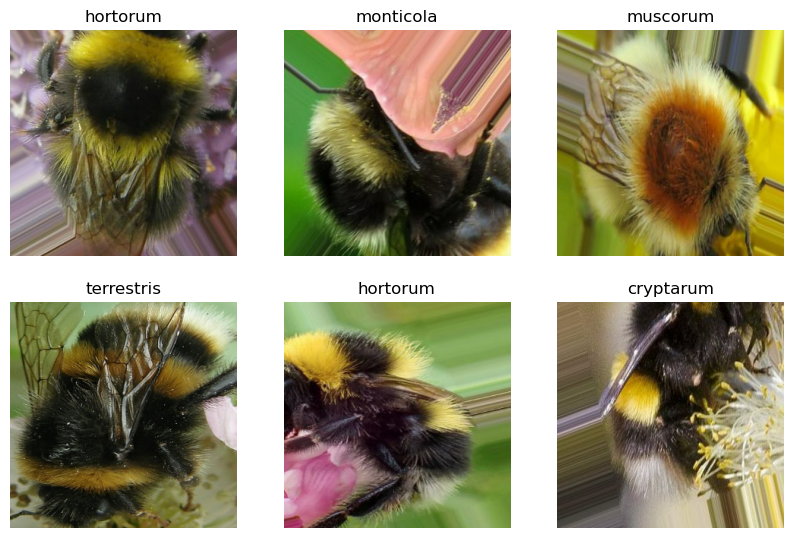

In [76]:
plt.figure(figsize=(10, 10))
for images, labels in train_batches_inception.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = labels[i].numpy().argmax()
        plt.title(class_names[label_index])
        plt.axis("off")

In [77]:
inceptionv3 = tf.keras.applications.InceptionV3(
    include_top=False,
    input_shape=(299, 299, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in inceptionv3.layers:
        layer.trainable=False

In [78]:
inceptionv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_297 (Conv2D)         (None, 149, 149, 32)         864       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_297 (B  (None, 149, 149, 32)         96        ['conv2d_297[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_297 (Activation  (None, 149, 149, 32)         0         ['batch_normalizati

                                                                                                  
 conv2d_308 (Conv2D)         (None, 35, 35, 32)           6144      ['average_pooling2d_10[0][0]']
                                                                                                  
 batch_normalization_302 (B  (None, 35, 35, 64)           192       ['conv2d_302[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_304 (B  (None, 35, 35, 64)           192       ['conv2d_304[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_307 (B  (None, 35, 35, 96)           288       ['conv2d_307[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_314 (Activation  (None, 35, 35, 96)           0         ['batch_normalization_314[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_315 (Activation  (None, 35, 35, 64)           0         ['batch_normalization_315[0][0
 )                                                                  ]']                           
                                                                                                  
 mixed1 (Concatenate)        (None, 35, 35, 288)          0         ['activation_309[0][0]',      
                                                                     'activation_311[0][0]',      
          

 )                                                                  ]']                           
                                                                                                  
 conv2d_325 (Conv2D)         (None, 35, 35, 96)           55296     ['activation_324[0][0]']      
                                                                                                  
 batch_normalization_325 (B  (None, 35, 35, 96)           288       ['conv2d_325[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_325 (Activation  (None, 35, 35, 96)           0         ['batch_normalization_325[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_32

                                                                                                  
 conv2d_327 (Conv2D)         (None, 17, 17, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_330 (Conv2D)         (None, 17, 17, 192)          172032    ['activation_329[0][0]']      
                                                                                                  
 conv2d_335 (Conv2D)         (None, 17, 17, 192)          172032    ['activation_334[0][0]']      
                                                                                                  
 conv2d_336 (Conv2D)         (None, 17, 17, 192)          147456    ['average_pooling2d_13[0][0]']
                                                                                                  
 batch_normalization_327 (B  (None, 17, 17, 192)          576       ['conv2d_327[0][0]']          
 atchNorma

 activation_344 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_344[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_14 (Aver  (None, 17, 17, 768)          0         ['mixed4[0][0]']              
 agePooling2D)                                                                                    
                                                                                                  
 conv2d_337 (Conv2D)         (None, 17, 17, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_340 (Conv2D)         (None, 17, 17, 192)          215040    ['activation_339[0][0]']      
                                                                                                  
 conv2d_34

 atchNormalization)                                                                               
                                                                                                  
 activation_349 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_349[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_354 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_354[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_15 (Aver  (None, 17, 17, 768)          0         ['mixed5[0][0]']              
 agePooling2D)                                                                                    
          

                                                                                                  
 batch_normalization_359 (B  (None, 17, 17, 192)          576       ['conv2d_359[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_364 (B  (None, 17, 17, 192)          576       ['conv2d_364[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_359 (Activation  (None, 17, 17, 192)          0         ['batch_normalization_359[0][0
 )                                                                  ]']                           
                                                                                                  
 activatio

 )                                                                  ]']                           
                                                                                                  
 conv2d_368 (Conv2D)         (None, 8, 8, 320)            552960    ['activation_367[0][0]']      
                                                                                                  
 conv2d_372 (Conv2D)         (None, 8, 8, 192)            331776    ['activation_371[0][0]']      
                                                                                                  
 batch_normalization_368 (B  (None, 8, 8, 320)            960       ['conv2d_368[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_372 (B  (None, 8, 8, 192)            576       ['conv2d_372[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_379 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_379[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_380 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_380[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_381 (B  (None, 8, 8, 192)            576       ['conv2d_381[0][0]']          
 atchNormalization)                                                                               
          

 )                                                                  ]']                           
                                                                                                  
 activation_385 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_385[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_388 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_388[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_389 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_389[0][0
 )                                                                  ]']                           
          

In [79]:
model_inceptionv3 = Sequential()

model_inceptionv3.add(inceptionv3)
model_inceptionv3.add(Flatten())
model_inceptionv3.add(Dense(512, activation='relu'))
model_inceptionv3.add(Dropout(0.5))
#model_inceptionv3.add(Dense(256, activation='relu'))
#model_inceptionv3.add(Dropout(0.5))
#model_inceptionv3.add(Dense(128, activation='relu'))
#model_inceptionv3.add(Dropout(0.5))
#model_resnet50.add(Dense(64, activation='relu'))
#model_resnet50.add(Dense(32, activation='relu'))
model_inceptionv3.add(Dense(21, activation='softmax'))

In [80]:
model_inceptionv3.summary()    

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 21)                10773     
                                                                 
Total params: 22862645 (87.21 MB)
Trainable params: 1059861 (4.04 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [81]:
model_inceptionv3.compile(optimizer=Adam(learning_rate=0.001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

In [82]:
epoch_inceptionv3 = 10

result_inceptionv3 = model_inceptionv3.fit(train_batches_inception,
                                           validation_data=validate_batches_inception,
                                           epochs=epoch_inceptionv3,
                                           verbose=2)

Epoch 1/10
172/172 - 153s - loss: 20.9288 - accuracy: 0.0491 - val_loss: 3.0464 - val_accuracy: 0.0409 - 153s/epoch - 892ms/step
Epoch 2/10
172/172 - 160s - loss: 3.1561 - accuracy: 0.0427 - val_loss: 3.0484 - val_accuracy: 0.0526 - 160s/epoch - 931ms/step
Epoch 3/10
172/172 - 161s - loss: 3.0469 - accuracy: 0.0415 - val_loss: 3.0484 - val_accuracy: 0.0402 - 161s/epoch - 936ms/step
Epoch 4/10
172/172 - 159s - loss: 3.0470 - accuracy: 0.0444 - val_loss: 3.0482 - val_accuracy: 0.0402 - 159s/epoch - 922ms/step
Epoch 5/10
172/172 - 161s - loss: 3.0474 - accuracy: 0.0442 - val_loss: 3.0488 - val_accuracy: 0.0402 - 161s/epoch - 936ms/step
Epoch 6/10
172/172 - 159s - loss: 3.0472 - accuracy: 0.0444 - val_loss: 3.0486 - val_accuracy: 0.0402 - 159s/epoch - 924ms/step
Epoch 7/10
172/172 - 159s - loss: 3.0472 - accuracy: 0.0387 - val_loss: 3.0490 - val_accuracy: 0.0402 - 159s/epoch - 925ms/step
Epoch 8/10
172/172 - 164s - loss: 3.0471 - accuracy: 0.0451 - val_loss: 3.0486 - val_accuracy: 0.0402 -

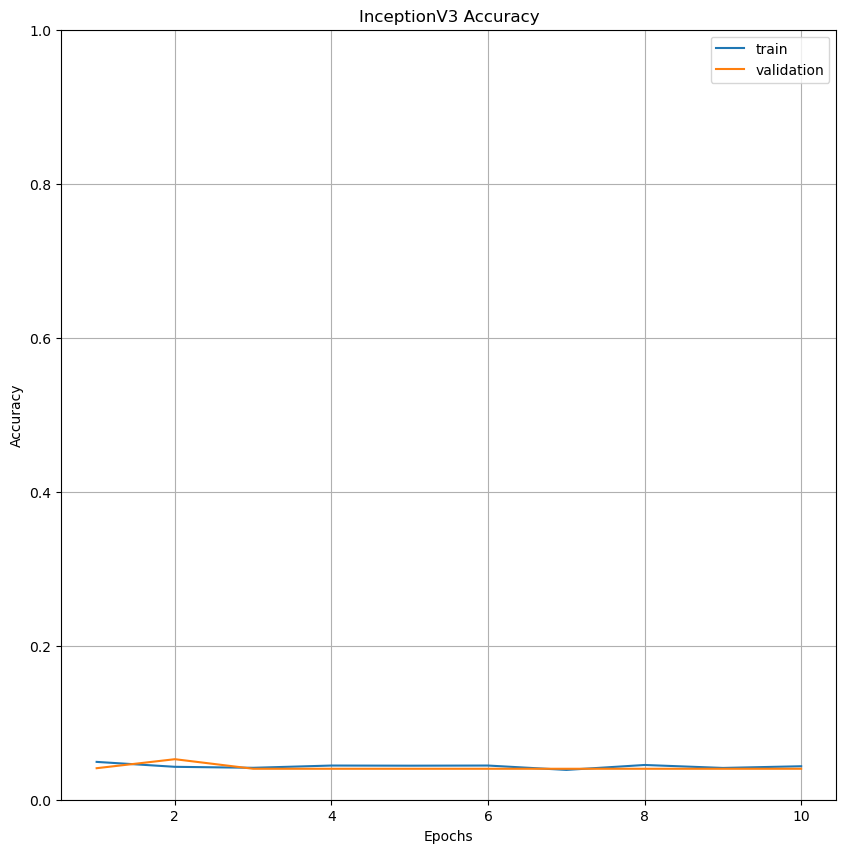

In [83]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_inceptionv3 + 1)
plt.plot(epochs_range, result_inceptionv3.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_inceptionv3.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('InceptionV3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

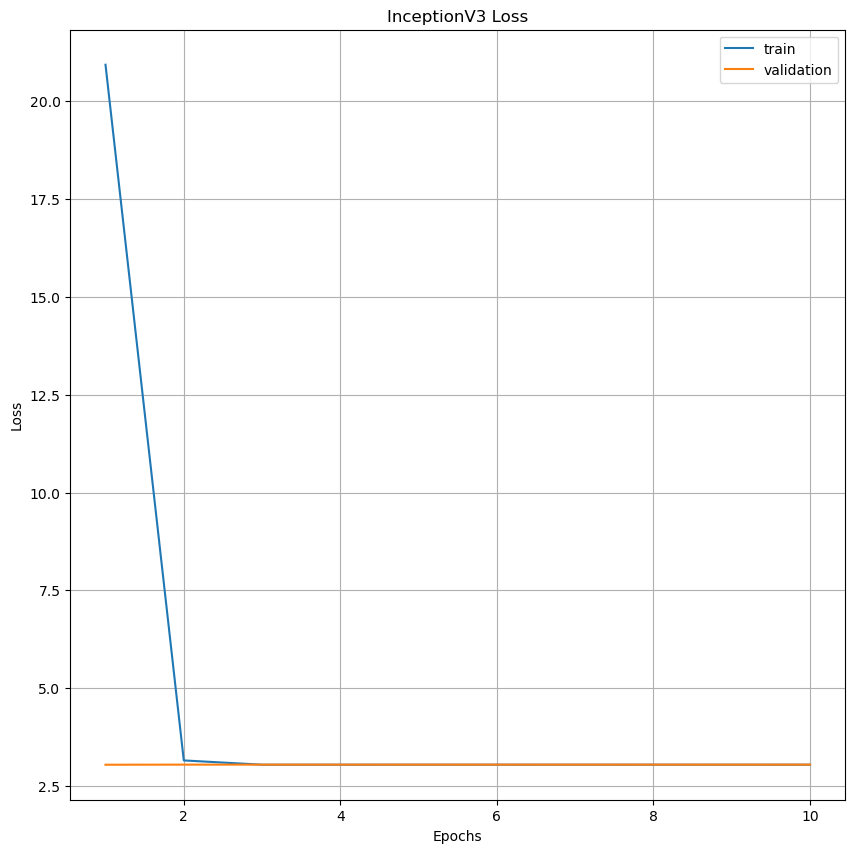

In [84]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_inceptionv3 + 1)
plt.plot(epochs_range, result_inceptionv3.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_inceptionv3.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('InceptionV3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## 4. MobileNetV2

In [50]:
mobilenetv2 = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in mobilenetv2.layers:
        layer.trainable=False

In [51]:
mobilenetv2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [52]:
model_mobilenetv2 = Sequential()

model_mobilenetv2.add(mobilenetv2)
model_mobilenetv2.add(Flatten())
model_mobilenetv2.add(Dense(512, activation='relu'))
model_mobilenetv2.add(Dropout(0.5))
#model_mobilenetv2.add(Dense(256, activation='relu'))
#model_mobilenetv2.add(Dropout(0.5))
#model_mobilenetv2.add(Dense(128, activation='relu'))
#model_mobilenetv2.add(Dropout(0.5))
#model_mobilenetv2.add(Dense(64, activation='relu'))
#model_mobilenetv2.add(Dense(32, activation='relu'))
model_mobilenetv2.add(Dense(21, activation='softmax'))

In [53]:
model_mobilenetv2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 21)                10773     
                                                                 
Total params: 2924629 (11.16 MB)
Trainable params: 666645 (2.54 MB)
Non-trainable params: 2257984 (8.61 MB)
____________

In [54]:
model_mobilenetv2.compile(optimizer=Adam(learning_rate=0.001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

In [55]:
epoch_mobilenetv2 = 10

result_mobilenetv2 = model_mobilenetv2.fit(train_batches,
                                           validation_data=validate_batches,
                                           epochs=epoch_mobilenetv2,
                                           verbose=2)

Epoch 1/10
172/172 - 45s - loss: 3.0238 - accuracy: 0.0963 - val_loss: 2.8034 - val_accuracy: 0.1455 - 45s/epoch - 259ms/step
Epoch 2/10
172/172 - 40s - loss: 2.7790 - accuracy: 0.1447 - val_loss: 2.6903 - val_accuracy: 0.1813 - 40s/epoch - 234ms/step
Epoch 3/10
172/172 - 42s - loss: 2.6711 - accuracy: 0.1744 - val_loss: 2.5791 - val_accuracy: 0.2025 - 42s/epoch - 246ms/step
Epoch 4/10
172/172 - 41s - loss: 2.5755 - accuracy: 0.1998 - val_loss: 2.5598 - val_accuracy: 0.2039 - 41s/epoch - 239ms/step
Epoch 5/10
172/172 - 41s - loss: 2.5286 - accuracy: 0.2139 - val_loss: 2.4760 - val_accuracy: 0.2412 - 41s/epoch - 237ms/step
Epoch 6/10
172/172 - 42s - loss: 2.4500 - accuracy: 0.2365 - val_loss: 2.4368 - val_accuracy: 0.2361 - 42s/epoch - 244ms/step
Epoch 7/10
172/172 - 41s - loss: 2.4175 - accuracy: 0.2438 - val_loss: 2.3912 - val_accuracy: 0.2485 - 41s/epoch - 237ms/step
Epoch 8/10
172/172 - 43s - loss: 2.3471 - accuracy: 0.2676 - val_loss: 2.3501 - val_accuracy: 0.2639 - 43s/epoch - 253

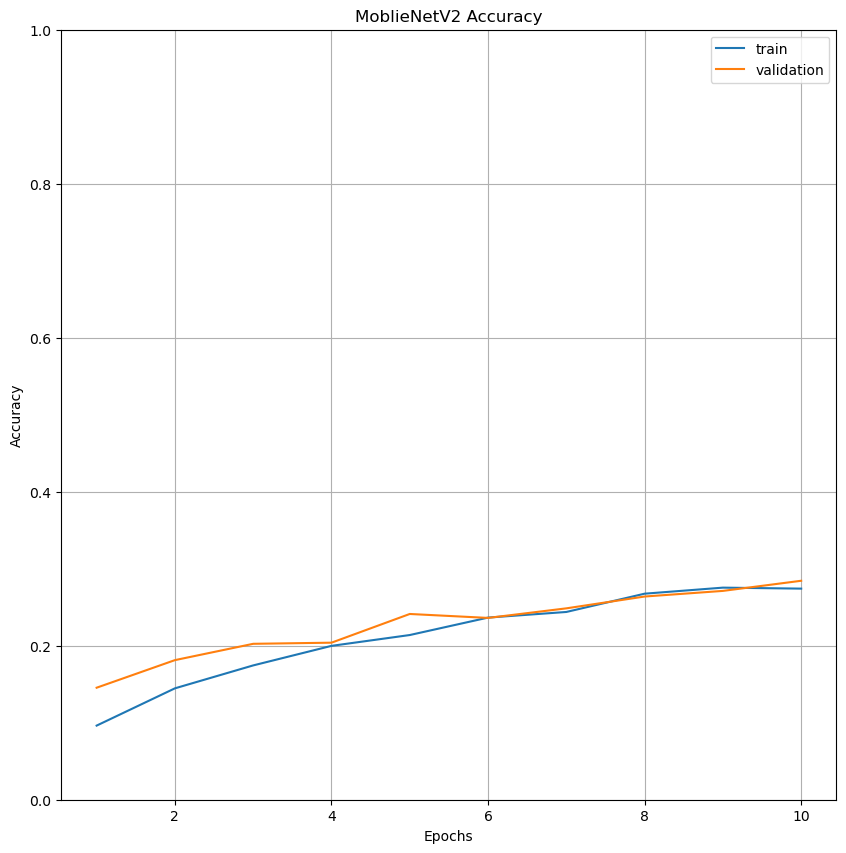

In [56]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_mobilenetv2 + 1)
plt.plot(epochs_range, result_mobilenetv2.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_mobilenetv2.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('MoblieNetV2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

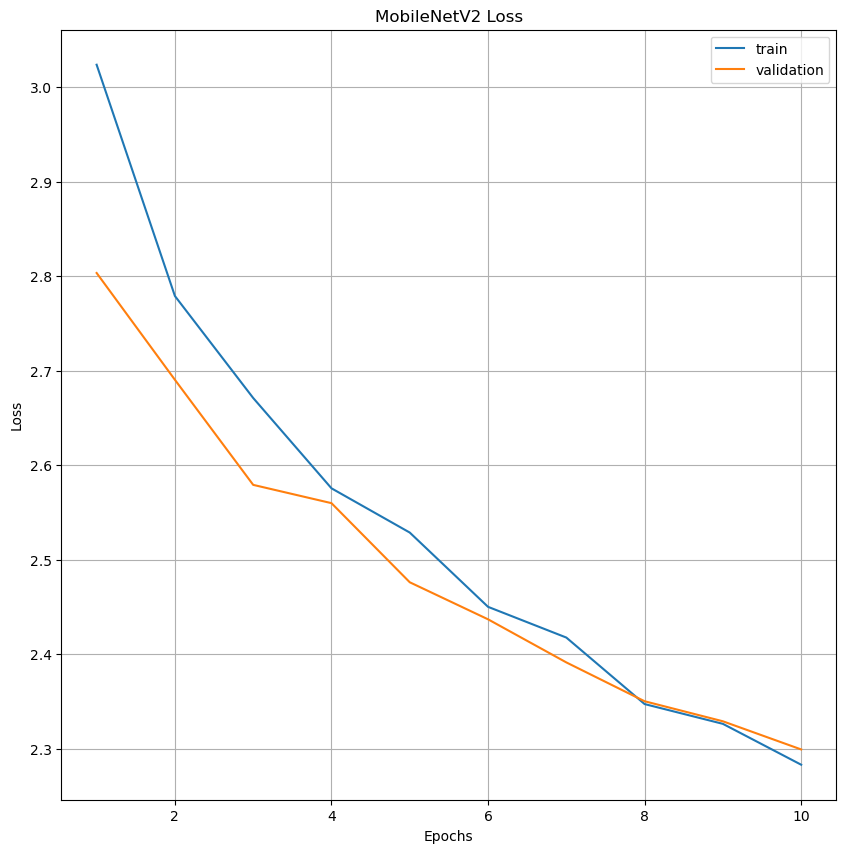

In [57]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_mobilenetv2 + 1)
plt.plot(epochs_range, result_mobilenetv2.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_mobilenetv2.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('MobileNetV2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## 5. VGG16

In [58]:
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in vgg16.layers:
        layer.trainable=False

In [59]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [60]:
model_vgg16 = Sequential()

model_vgg16.add(vgg16)
model_vgg16.add(Flatten())
model_vgg16.add(Dense(512, activation='relu'))
model_vgg16.add(Dropout(0.5))
#model_vgg16.add(Dense(256, activation='relu'))
#model_vgg16.add(Dropout(0.5))
#model_vgg16.add(Dense(128, activation='relu'))
#model_vgg16.add(Dropout(0.5))
#model_vgg16.add(Dense(64, activation='relu'))
#model_vgg16.add(Dense(32, activation='relu'))
model_vgg16.add(Dense(21, activation='softmax'))

In [61]:
model_vgg16.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 21)                10773     
                                                                 
Total params: 14988117 (57.18 MB)
Trainable params: 273429 (1.04 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [62]:
model_vgg16.compile(optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [63]:
epoch_vgg16 = 10

result_vgg16 = model_vgg16.fit(train_batches,
                               validation_data=validate_batches,
                               epochs=epoch_vgg16,
                               verbose=2)

Epoch 1/10
172/172 - 301s - loss: 3.8658 - accuracy: 0.1302 - val_loss: 2.5452 - val_accuracy: 0.2639 - 301s/epoch - 2s/step
Epoch 2/10
172/172 - 301s - loss: 2.4276 - accuracy: 0.2579 - val_loss: 2.0696 - val_accuracy: 0.3787 - 301s/epoch - 2s/step
Epoch 3/10
172/172 - 303s - loss: 2.0410 - accuracy: 0.3595 - val_loss: 1.7592 - val_accuracy: 0.4985 - 303s/epoch - 2s/step
Epoch 4/10
172/172 - 352s - loss: 1.7813 - accuracy: 0.4287 - val_loss: 1.5462 - val_accuracy: 0.5212 - 352s/epoch - 2s/step
Epoch 5/10
172/172 - 323s - loss: 1.6067 - accuracy: 0.4921 - val_loss: 1.3517 - val_accuracy: 0.5863 - 323s/epoch - 2s/step
Epoch 6/10
172/172 - 400s - loss: 1.4071 - accuracy: 0.5452 - val_loss: 1.2138 - val_accuracy: 0.6272 - 400s/epoch - 2s/step
Epoch 7/10
172/172 - 398s - loss: 1.2484 - accuracy: 0.5858 - val_loss: 1.1188 - val_accuracy: 0.6477 - 398s/epoch - 2s/step
Epoch 8/10
172/172 - 409s - loss: 1.1883 - accuracy: 0.6084 - val_loss: 1.0715 - val_accuracy: 0.6813 - 409s/epoch - 2s/step


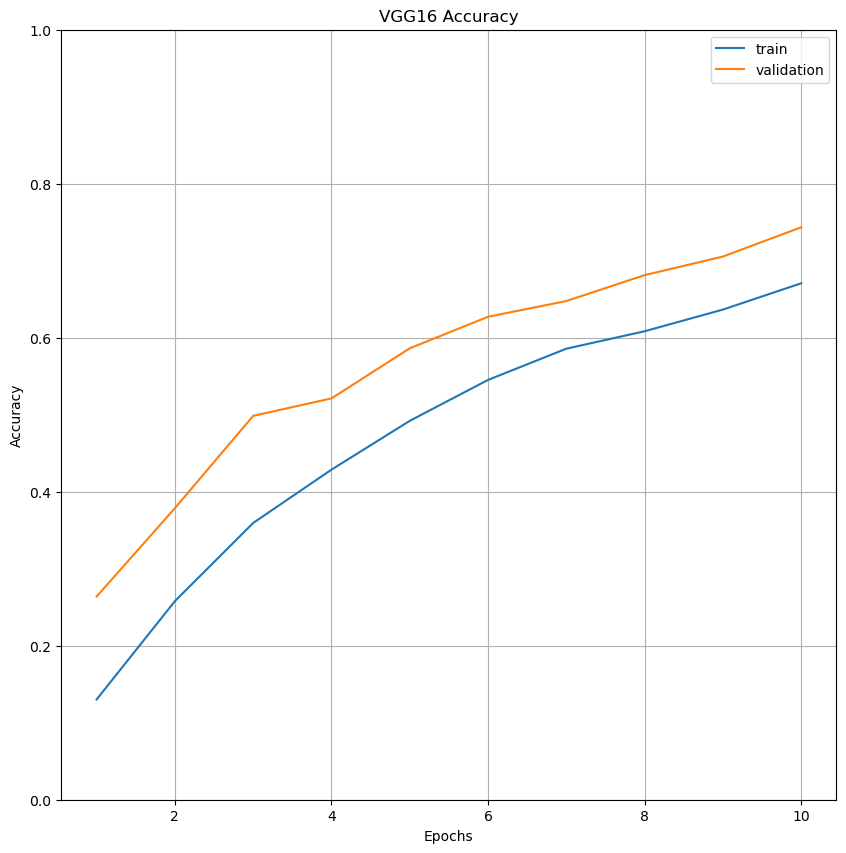

In [64]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_vgg16 + 1)
plt.plot(epochs_range, result_vgg16.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_vgg16.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('VGG16 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

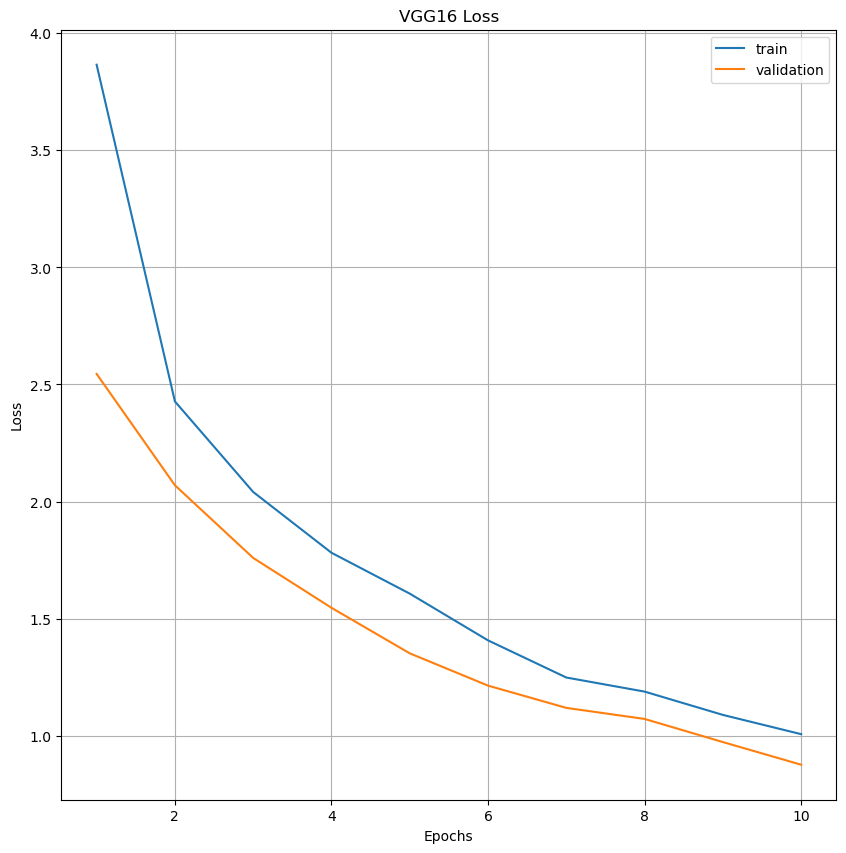

In [65]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_vgg16 + 1)
plt.plot(epochs_range, result_vgg16.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_vgg16.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('VGG16 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## 6. InceptionResnetV2

In [85]:
inceptionresnetv2 = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    input_shape=(299, 299, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in inceptionresnetv2.layers:
        layer.trainable=False

In [86]:
inceptionresnetv2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_391 (Conv2D)         (None, 149, 149, 32)         864       ['input_8[0][0]']             
                                                                                                  
 batch_normalization_391 (B  (None, 149, 149, 32)         96        ['conv2d_391[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_391 (Activation  (None, 149, 149, 32)         0         ['batch_norm

                                                                                                  
 conv2d_402 (Conv2D)         (None, 35, 35, 64)           12288     ['average_pooling2d_19[0][0]']
                                                                                                  
 batch_normalization_396 (B  (None, 35, 35, 96)           288       ['conv2d_396[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_398 (B  (None, 35, 35, 64)           192       ['conv2d_398[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_401 (B  (None, 35, 35, 96)           288       ['conv2d_401[0][0]']          
 atchNorma

                                                                                                  
 block35_1_conv (Conv2D)     (None, 35, 35, 320)          41280     ['block35_1_mixed[0][0]']     
                                                                                                  
 custom_scale_layer_40 (Cus  (None, 35, 35, 320)          0         ['mixed_5b[0][0]',            
 tomScaleLayer)                                                      'block35_1_conv[0][0]']      
                                                                                                  
 block35_1_ac (Activation)   (None, 35, 35, 320)          0         ['custom_scale_layer_40[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_412 (Conv2D)         (None, 35, 35, 32)           10240     ['block35_1_ac[0][0]']        
          

                                                                                                  
 batch_normalization_419 (B  (None, 35, 35, 48)           144       ['conv2d_419[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_416 (Activation  (None, 35, 35, 32)           0         ['batch_normalization_416[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_419 (Activation  (None, 35, 35, 48)           0         ['batch_normalization_419[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_41

 atchNormalization)                                                                               
                                                                                                  
 activation_421 (Activation  (None, 35, 35, 32)           0         ['batch_normalization_421[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_423 (Activation  (None, 35, 35, 32)           0         ['batch_normalization_423[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_426 (Activation  (None, 35, 35, 64)           0         ['batch_normalization_426[0][0
 )                                                                  ]']                           
          

 conv2d_436 (Conv2D)         (None, 35, 35, 32)           10240     ['block35_5_ac[0][0]']        
                                                                                                  
 batch_normalization_436 (B  (None, 35, 35, 32)           96        ['conv2d_436[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_436 (Activation  (None, 35, 35, 32)           0         ['batch_normalization_436[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_434 (Conv2D)         (None, 35, 35, 32)           10240     ['block35_5_ac[0][0]']        
                                                                                                  
 conv2d_43

                                                                                                  
 conv2d_439 (Conv2D)         (None, 35, 35, 32)           10240     ['block35_6_ac[0][0]']        
                                                                                                  
 conv2d_441 (Conv2D)         (None, 35, 35, 32)           9216      ['activation_440[0][0]']      
                                                                                                  
 conv2d_444 (Conv2D)         (None, 35, 35, 64)           27648     ['activation_443[0][0]']      
                                                                                                  
 batch_normalization_439 (B  (None, 35, 35, 32)           96        ['conv2d_439[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_nor

 )                                                                  ]']                           
                                                                                                  
 block35_8_mixed (Concatena  (None, 35, 35, 128)          0         ['activation_445[0][0]',      
 te)                                                                 'activation_447[0][0]',      
                                                                     'activation_450[0][0]']      
                                                                                                  
 block35_8_conv (Conv2D)     (None, 35, 35, 320)          41280     ['block35_8_mixed[0][0]']     
                                                                                                  
 custom_scale_layer_47 (Cus  (None, 35, 35, 320)          0         ['block35_7_ac[0][0]',        
 tomScaleLayer)                                                      'block35_8_conv[0][0]']      
          

                                                                                                  
 conv2d_461 (Conv2D)         (None, 35, 35, 48)           13824     ['activation_460[0][0]']      
                                                                                                  
 batch_normalization_458 (B  (None, 35, 35, 32)           96        ['conv2d_458[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_461 (B  (None, 35, 35, 48)           144       ['conv2d_461[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_458 (Activation  (None, 35, 35, 32)           0         ['batch_normalization_458[0][0
 )        

 max_pooling2d_14 (MaxPooli  (None, 17, 17, 320)          0         ['block35_10_ac[0][0]']       
 ng2D)                                                                                            
                                                                                                  
 mixed_6a (Concatenate)      (None, 17, 17, 1088)         0         ['activation_463[0][0]',      
                                                                     'activation_466[0][0]',      
                                                                     'max_pooling2d_14[0][0]']    
                                                                                                  
 conv2d_468 (Conv2D)         (None, 17, 17, 128)          139264    ['mixed_6a[0][0]']            
                                                                                                  
 batch_normalization_468 (B  (None, 17, 17, 128)          384       ['conv2d_468[0][0]']          
 atchNorma

 te)                                                                 'activation_474[0][0]']      
                                                                                                  
 block17_2_conv (Conv2D)     (None, 17, 17, 1088)         418880    ['block17_2_mixed[0][0]']     
                                                                                                  
 custom_scale_layer_51 (Cus  (None, 17, 17, 1088)         0         ['block17_1_ac[0][0]',        
 tomScaleLayer)                                                      'block17_2_conv[0][0]']      
                                                                                                  
 block17_2_ac (Activation)   (None, 17, 17, 1088)         0         ['custom_scale_layer_51[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_47

 )                                                                  ]']                           
                                                                                                  
 block17_4_mixed (Concatena  (None, 17, 17, 384)          0         ['activation_479[0][0]',      
 te)                                                                 'activation_482[0][0]']      
                                                                                                  
 block17_4_conv (Conv2D)     (None, 17, 17, 1088)         418880    ['block17_4_mixed[0][0]']     
                                                                                                  
 custom_scale_layer_53 (Cus  (None, 17, 17, 1088)         0         ['block17_3_ac[0][0]',        
 tomScaleLayer)                                                      'block17_4_conv[0][0]']      
                                                                                                  
 block17_4

 )                                                                  ]']                           
                                                                                                  
 activation_490 (Activation  (None, 17, 17, 192)          0         ['batch_normalization_490[0][0
 )                                                                  ]']                           
                                                                                                  
 block17_6_mixed (Concatena  (None, 17, 17, 384)          0         ['activation_487[0][0]',      
 te)                                                                 'activation_490[0][0]']      
                                                                                                  
 block17_6_conv (Conv2D)     (None, 17, 17, 1088)         418880    ['block17_6_mixed[0][0]']     
                                                                                                  
 custom_sc

 atchNormalization)                                                                               
                                                                                                  
 activation_495 (Activation  (None, 17, 17, 192)          0         ['batch_normalization_495[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_498 (Activation  (None, 17, 17, 192)          0         ['batch_normalization_498[0][0
 )                                                                  ]']                           
                                                                                                  
 block17_8_mixed (Concatena  (None, 17, 17, 384)          0         ['activation_495[0][0]',      
 te)                                                                 'activation_498[0][0]']      
          

 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_506 (B  (None, 17, 17, 192)          576       ['conv2d_506[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_503 (Activation  (None, 17, 17, 192)          0         ['batch_normalization_503[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_506 (Activation  (None, 17, 17, 192)          0         ['batch_normalization_506[0][0
 )                                                                  ]']                           
          

 conv2d_514 (Conv2D)         (None, 17, 17, 192)          215040    ['activation_513[0][0]']      
                                                                                                  
 batch_normalization_511 (B  (None, 17, 17, 192)          576       ['conv2d_511[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_514 (B  (None, 17, 17, 192)          576       ['conv2d_514[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_511 (Activation  (None, 17, 17, 192)          0         ['batch_normalization_511[0][0
 )                                                                  ]']                           
          

                                                                                                  
 conv2d_519 (Conv2D)         (None, 17, 17, 192)          208896    ['block17_13_ac[0][0]']       
                                                                                                  
 conv2d_522 (Conv2D)         (None, 17, 17, 192)          215040    ['activation_521[0][0]']      
                                                                                                  
 batch_normalization_519 (B  (None, 17, 17, 192)          576       ['conv2d_519[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_522 (B  (None, 17, 17, 192)          576       ['conv2d_522[0][0]']          
 atchNormalization)                                                                               
          

                                                                                                  
 activation_529 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_529[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_527 (Conv2D)         (None, 17, 17, 192)          208896    ['block17_15_ac[0][0]']       
                                                                                                  
 conv2d_530 (Conv2D)         (None, 17, 17, 192)          215040    ['activation_529[0][0]']      
                                                                                                  
 batch_normalization_527 (B  (None, 17, 17, 192)          576       ['conv2d_527[0][0]']          
 atchNormalization)                                                                               
          

                                                                                                  
 batch_normalization_537 (B  (None, 17, 17, 160)          480       ['conv2d_537[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_537 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_537[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_535 (Conv2D)         (None, 17, 17, 192)          208896    ['block17_17_ac[0][0]']       
                                                                                                  
 conv2d_538 (Conv2D)         (None, 17, 17, 192)          215040    ['activation_537[0][0]']      
          

 )                                                                  ]']                           
                                                                                                  
 conv2d_545 (Conv2D)         (None, 17, 17, 160)          143360    ['activation_544[0][0]']      
                                                                                                  
 batch_normalization_545 (B  (None, 17, 17, 160)          480       ['conv2d_545[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_545 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_545[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_54

                                                                                                  
 activation_548 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_548[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_550 (Activation  (None, 8, 8, 288)            0         ['batch_normalization_550[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_553 (Activation  (None, 8, 8, 320)            0         ['batch_normalization_553[0][0
 )                                                                  ]']                           
                                                                                                  
 max_pooli

                                                                                                  
 batch_normalization_561 (B  (None, 8, 8, 256)            768       ['conv2d_561[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_558 (Activation  (None, 8, 8, 192)            0         ['batch_normalization_558[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_561 (Activation  (None, 8, 8, 256)            0         ['batch_normalization_561[0][0
 )                                                                  ]']                           
                                                                                                  
 block8_2_

                                                                                                  
 batch_normalization_566 (B  (None, 8, 8, 192)            576       ['conv2d_566[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_569 (B  (None, 8, 8, 256)            768       ['conv2d_569[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_566 (Activation  (None, 8, 8, 192)            0         ['batch_normalization_566[0][0
 )                                                                  ]']                           
                                                                                                  
 activatio

 conv2d_574 (Conv2D)         (None, 8, 8, 192)            399360    ['block8_5_ac[0][0]']         
                                                                                                  
 conv2d_577 (Conv2D)         (None, 8, 8, 256)            172032    ['activation_576[0][0]']      
                                                                                                  
 batch_normalization_574 (B  (None, 8, 8, 192)            576       ['conv2d_574[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_577 (B  (None, 8, 8, 256)            768       ['conv2d_577[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activatio

 activation_584 (Activation  (None, 8, 8, 224)            0         ['batch_normalization_584[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_582 (Conv2D)         (None, 8, 8, 192)            399360    ['block8_7_ac[0][0]']         
                                                                                                  
 conv2d_585 (Conv2D)         (None, 8, 8, 256)            172032    ['activation_584[0][0]']      
                                                                                                  
 batch_normalization_582 (B  (None, 8, 8, 192)            576       ['conv2d_582[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_nor

 batch_normalization_592 (B  (None, 8, 8, 224)            672       ['conv2d_592[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_592 (Activation  (None, 8, 8, 224)            0         ['batch_normalization_592[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_590 (Conv2D)         (None, 8, 8, 192)            399360    ['block8_9_ac[0][0]']         
                                                                                                  
 conv2d_593 (Conv2D)         (None, 8, 8, 256)            172032    ['activation_592[0][0]']      
                                                                                                  
 batch_nor

In [87]:
model_inceptionresnetv2 = Sequential()

model_inceptionresnetv2.add(inceptionresnetv2)
model_inceptionresnetv2.add(Flatten())
model_inceptionresnetv2.add(Dense(512, activation='relu'))
model_inceptionresnetv2.add(Dropout(0.5))
#model_inceptionresnetv2.add(Dense(256, activation='relu'))
#model_inceptionresnetv2.add(Dropout(0.5))
#model_inceptionresnetv2.add(Dense(128, activation='relu'))
#model_inceptionresnetv2.add(Dropout(0.5))
#model_inceptionresnetv2.add(Dense(64, activation='relu'))
#model_inceptionresnetv2.add(Dense(32, activation='relu'))
model_inceptionresnetv2.add(Dense(21, activation='softmax'))

In [88]:
model_inceptionresnetv2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 1536)              54336736  
 ional)                                                          
                                                                 
 flatten_7 (Flatten)         (None, 1536)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               786944    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 21)                10773     
                                                                 
Total params: 55134453 (210.32 MB)
Trainable params: 797717 (3.04 MB)
Non-trainable params: 54336736 (207.28 MB)
_______

In [89]:
model_inceptionresnetv2.compile(optimizer=Adam(learning_rate=0.001),
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

In [90]:
epoch_inceptionresnetv2 = 10

result_inceptionresnetv2 = model_inceptionresnetv2.fit(train_batches_inception,
                                    validation_data=validate_batches_inception,
                                                epochs=epoch_inceptionresnetv2,
                                                                     verbose=2)

Epoch 1/10
172/172 - 593s - loss: 23.1436 - accuracy: 0.0446 - val_loss: 3.0451 - val_accuracy: 0.0446 - 593s/epoch - 3s/step
Epoch 2/10
172/172 - 460s - loss: 3.1400 - accuracy: 0.0491 - val_loss: 3.0459 - val_accuracy: 0.0446 - 460s/epoch - 3s/step
Epoch 3/10
172/172 - 446s - loss: 3.1711 - accuracy: 0.0464 - val_loss: 3.0462 - val_accuracy: 0.0373 - 446s/epoch - 3s/step
Epoch 4/10
172/172 - 451s - loss: 3.0446 - accuracy: 0.0464 - val_loss: 3.0466 - val_accuracy: 0.0446 - 451s/epoch - 3s/step
Epoch 5/10
172/172 - 448s - loss: 3.0446 - accuracy: 0.0447 - val_loss: 3.0468 - val_accuracy: 0.0402 - 448s/epoch - 3s/step
Epoch 6/10
172/172 - 449s - loss: 3.0445 - accuracy: 0.0449 - val_loss: 3.0470 - val_accuracy: 0.0373 - 449s/epoch - 3s/step
Epoch 7/10
172/172 - 444s - loss: 3.0445 - accuracy: 0.0480 - val_loss: 3.0474 - val_accuracy: 0.0402 - 444s/epoch - 3s/step
Epoch 8/10
172/172 - 442s - loss: 3.0445 - accuracy: 0.0473 - val_loss: 3.0476 - val_accuracy: 0.0373 - 442s/epoch - 3s/step

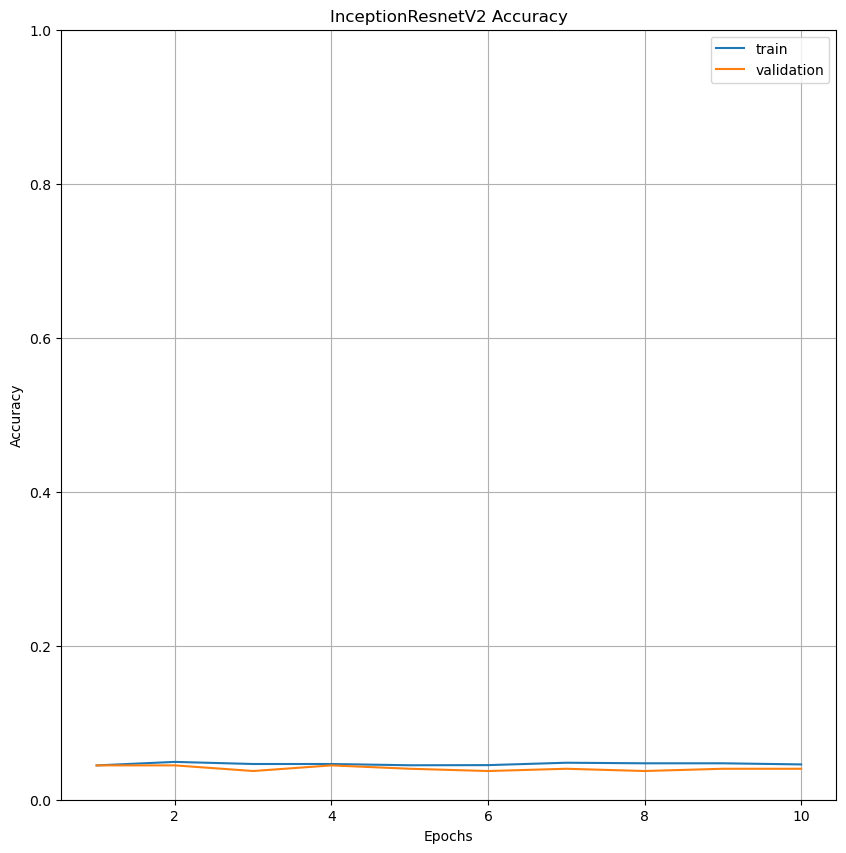

In [91]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_inceptionresnetv2 + 1)
plt.plot(epochs_range, result_inceptionresnetv2.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_inceptionresnetv2.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('InceptionResnetV2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

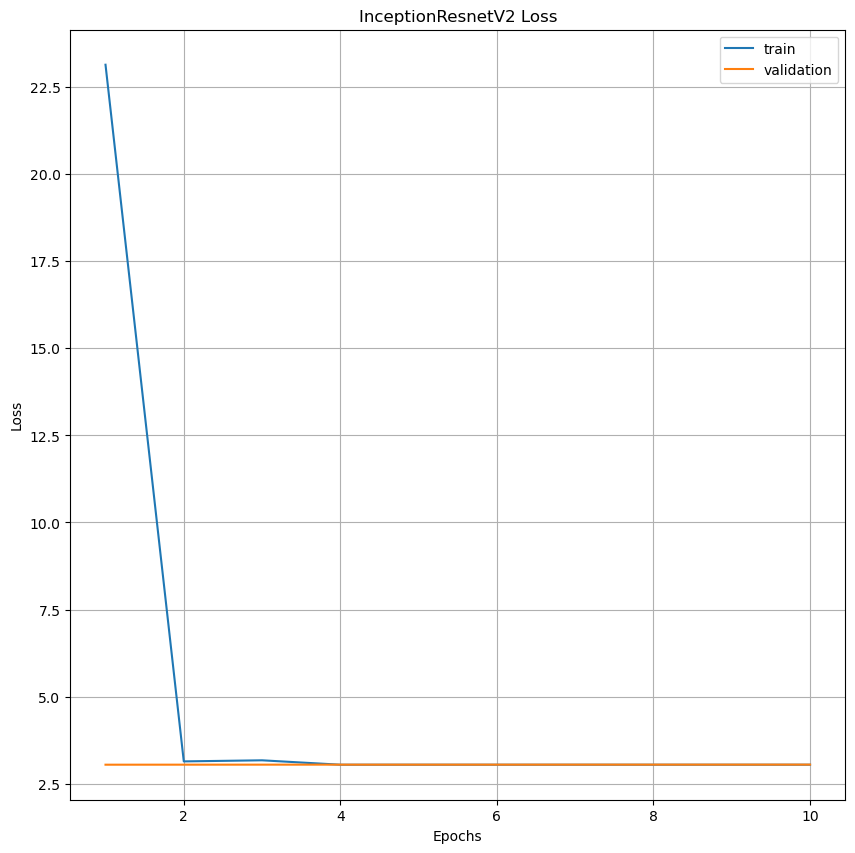

In [92]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_inceptionresnetv2 + 1)
plt.plot(epochs_range, result_inceptionresnetv2.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_inceptionresnetv2.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('InceptionResnetV2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## Local Interpretable Model-agnostic Explanations (LIME)

In [93]:
#!pip3 install lime

In [128]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from keras.preprocessing import image
from tensorflow.keras.applications import resnet50, vgg16, vgg19, mobilenet_v2
from tensorflow.keras.applications import inception_v3, inception_resnet_v2
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread


from functools import partial

In [142]:
def transform_img_fn(path_list, model):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(img_height, img_width))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = model.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

- **ResNet50**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 50ms/step
Class: barbutellus, Confidence: 0.7286431193351746
Class: hortorum, Confidence: 0.13482490181922913
Class: campestris, Confidence: 0.030595339834690094
Class: sylvestris, Confidence: 0.030013330280780792
Class: rupestris, Confidence: 0.015172774903476238
Class: pratorum, Confidence: 0.014991234987974167
Class: bohemicus, Confidence: 0.013886835426092148
Class: hypnorum, Confidence: 0.012860890477895737
Class: sylvarum, Confidence: 0.005953764542937279
Class: monticola, Confidence: 0.0055061038583517075
Class: lapidarius, Confidence: 0.002309567527845502
Class: muscorum, Confidence: 0.002095082774758339
Class: jonellus, Confidence: 0.0014242471661418676
Class: pascuorum, Confidence: 0.0008671693503856659
Class: vestalis, Confidence: 0.0004180948017165065
Class: ruderarius, Confidence: 0.00026653672102838755
Class: terrestris, Confidence: 0.00011845512926811352
Class: lucorum, Confidence: 3.020338772330433e-05
Class: distinguendus, Conf

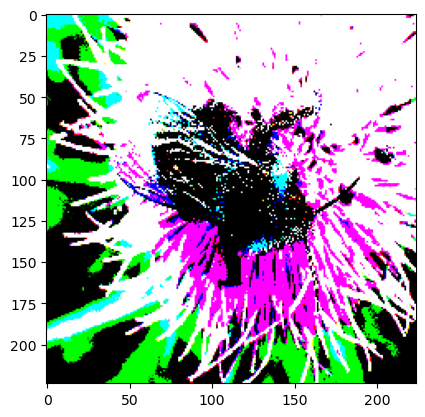

In [143]:
image_barbutellus = transform_img_fn([os.path.join('/home/hduser/Desktop/testing dataset/bombus barbutellus',
                                                   'bombus barbutellus male 29.jpg')], resnet50)
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(image_barbutellus[0] / 2 + 0.5)

preds = model_resnet50.predict(image_barbutellus)
# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

In [130]:
explainer = lime_image.LimeImageExplainer()

In [131]:
explanation = explainer.explain_instance(image_barbutellus[0].astype('double'), 
                                         model_resnet50.predict, 
                                         top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 217ms/step


<br> </br>
- top 5 superpixels that are most positive towards the class

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


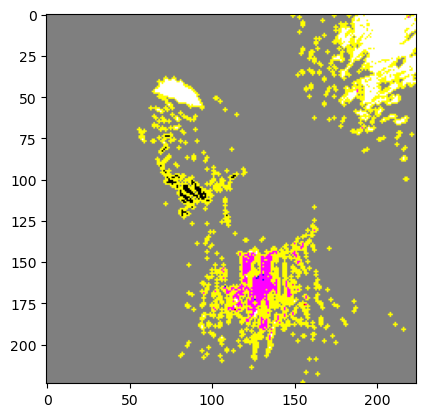

In [132]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


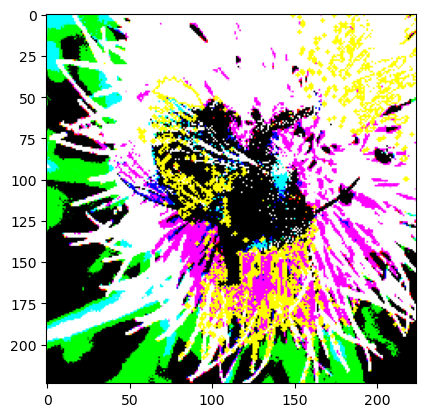

In [133]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- pros and cons (pros in green, cons in red)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


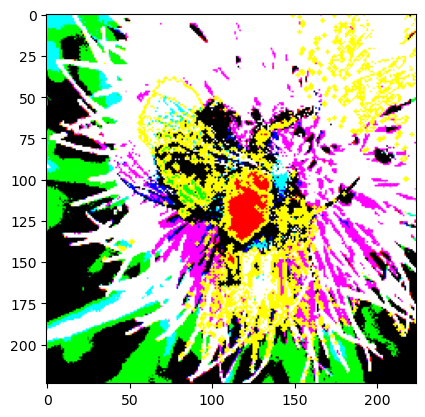

In [134]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, 
                                            num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- the pros and cons that have weight at least 0.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


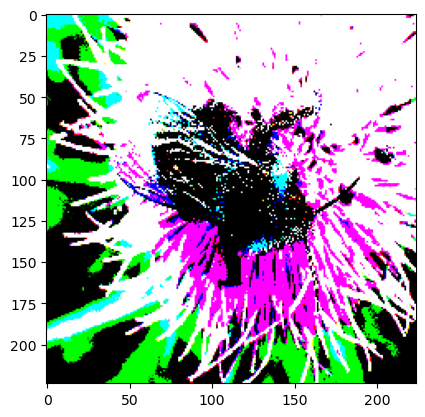

In [135]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, num_features=1000, 
                                            hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- heatmap visualization

In [136]:
def plot_heatmap(explanation, default_value=0):
    # Select the top class from the explanation
    ind = explanation.top_labels[0]

    # Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])

    # Create a custom function to handle default value
    def get_with_default(key):
        return dict_heatmap.get(key, default_value)

    # Vectorize the function using np.vectorize
    vectorized_get_with_default = np.vectorize(get_with_default, otypes=[np.float64])
    heatmap = vectorized_get_with_default(explanation.segments)

    # Plot. The visualization makes more sense if a symmetrical colorbar is used.
    plt.imshow(heatmap, cmap='RdBu', vmin=-np.max(np.abs(heatmap)), vmax=np.max(np.abs(heatmap)))
    plt.colorbar()
    plt.show()

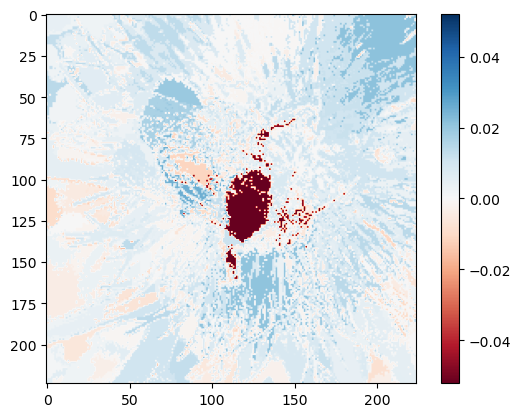

In [137]:
plot_heatmap(explanation)

In [138]:
# #Select the same class explained on the figures above.
# ind =  explanation.top_labels[0]

# #Map each explanation weight to the corresponding superpixel
# dict_heatmap = dict(explanation.local_exp[ind])

# # Set default value for None entries
# default_value = 0  # You can adjust this value based on your preferences

# # Create a custom function to handle default value
# def get_with_default(key):
#     return dict_heatmap.get(key, default_value)

# # Vectorize the function using np.vectorize
# vectorized_get_with_default = np.vectorize(get_with_default, otypes=[np.float64])
# heatmap = vectorized_get_with_default(explanation.segments)

# # Plot. The visualization makes more sense if a symmetrical colorbar is used.
# plt.imshow(heatmap, cmap='RdBu', vmin=-np.max(np.abs(heatmap)), vmax=np.max(np.abs(heatmap)))
# plt.colorbar()
# plt.show()

In [139]:
# Second label

# temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], 
#                                             positive_only=True, 
#                                             num_features=5, hide_rest=True)
# plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 61ms/step
Class: bohemicus, Confidence: 0.5715182423591614
Class: pratorum, Confidence: 0.09632089734077454
Class: sylvestris, Confidence: 0.09225122630596161
Class: barbutellus, Confidence: 0.06778904795646667
Class: sylvarum, Confidence: 0.04549727961421013
Class: rupestris, Confidence: 0.0384325310587883
Class: hortorum, Confidence: 0.03559087961912155
Class: campestris, Confidence: 0.020042836666107178
Class: jonellus, Confidence: 0.013620177283883095
Class: monticola, Confidence: 0.008324344642460346
Class: ruderarius, Confidence: 0.005211534444242716
Class: lapidarius, Confidence: 0.003666602773591876
Class: vestalis, Confidence: 0.0005325070815160871
Class: hypnorum, Confidence: 0.00032409693812951446
Class: magnus, Confidence: 0.0002502806019037962
Class: cryptarum, Confidence: 0.00022414178238250315
Class: terrestris, Confidence: 0.00020715262508019805
Class: pascuorum, Confidence: 0.00011901570542249829
Class: lucorum, Confidence: 7.1

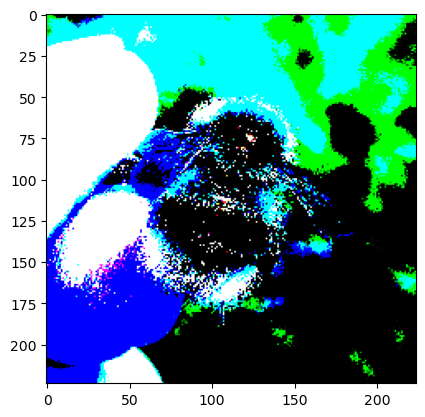

In [144]:
image_bohemicus = transform_img_fn([os.path.join('/home/hduser/Desktop/testing dataset/bombus bohemicus',
                                                 'bombus bohemicus male 9.jpg')], resnet50)
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(image_bohemicus[0] / 2 + 0.5)

preds = model_resnet50.predict(image_bohemicus)
# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

In [145]:
explanation = explainer.explain_instance(image_bohemicus[0].astype('double'), 
                                         model_resnet50.predict, 
                                         top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 247ms/step


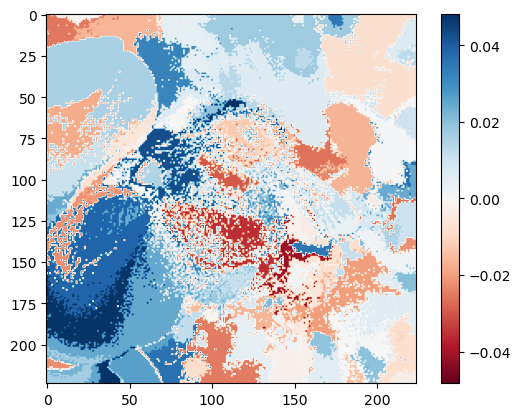

In [146]:
plot_heatmap(explanation)

<br> </br>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 42ms/step
Class: bohemicus, Confidence: 0.39133259654045105
Class: jonellus, Confidence: 0.22535039484500885
Class: sylvarum, Confidence: 0.12176687270402908
Class: barbutellus, Confidence: 0.1002122163772583
Class: pratorum, Confidence: 0.04733389988541603
Class: monticola, Confidence: 0.028504986315965652
Class: hortorum, Confidence: 0.021845374256372452
Class: ruderarius, Confidence: 0.013050870038568974
Class: campestris, Confidence: 0.012621928937733173
Class: sylvestris, Confidence: 0.008800260722637177
Class: hypnorum, Confidence: 0.00862419418990612
Class: lapidarius, Confidence: 0.005575106013566256
Class: rupestris, Confidence: 0.004148644395172596
Class: pascuorum, Confidence: 0.0035466807894408703
Class: cryptarum, Confidence: 0.003366422140970826
Class: magnus, Confidence: 0.0018443375593051314
Class: terrestris, Confidence: 0.0006723139085806906
Class: lucorum, Confidence: 0.0005579774151556194
Class: muscorum, Confidence: 0.00033

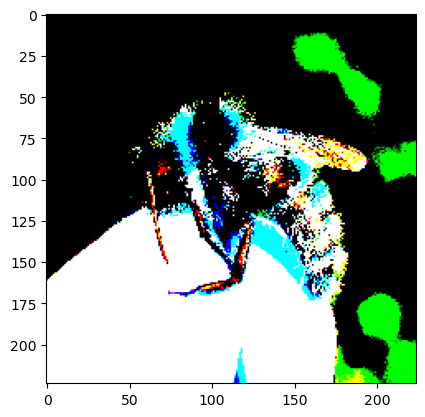

In [150]:
image_campestris = transform_img_fn([os.path.join('/home/hduser/Desktop/testing dataset/bombus campestris',
                                                  'bombus campestris male 7.jpg')], resnet50)
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(image_campestris[0] / 2 + 0.5)

preds = model_resnet50.predict(image_campestris)
# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

In [151]:
explanation = explainer.explain_instance(image_campestris[0].astype('double'), 
                                         model_resnet50.predict, 
                                         top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 231ms/step


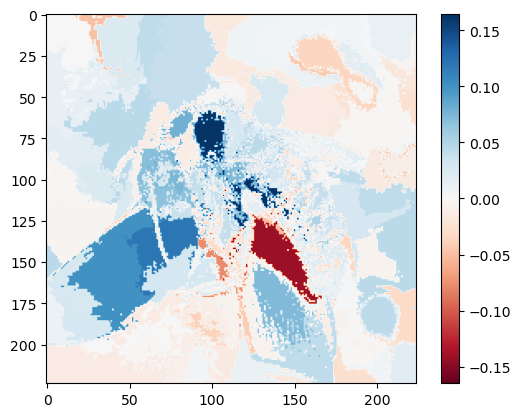

In [152]:
plot_heatmap(explanation)

- **VGG19**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 87ms/step
Class: bohemicus, Confidence: 0.9893408417701721
Class: cryptarum, Confidence: 0.008358767256140709
Class: barbutellus, Confidence: 0.0018797294469550252
Class: vestalis, Confidence: 0.00015086996427271515
Class: hortorum, Confidence: 0.00013106346887070686
Class: rupestris, Confidence: 4.078439815202728e-05
Class: lapidarius, Confidence: 2.8149941499577835e-05
Class: jonellus, Confidence: 2.5737950636539608e-05
Class: pratorum, Confidence: 2.0306915757828392e-05
Class: terrestris, Confidence: 9.10775543161435e-06
Class: lucorum, Confidence: 6.766121259715874e-06
Class: magnus, Confidence: 3.3948103919101413e-06
Class: campestris, Confidence: 3.180733756380505e-06
Class: monticola, Confidence: 1.1378426734154345e-06
Class: sylvestris, Confidence: 1.100566038303441e-07
Class: muscorum, Confidence: 4.587946733636272e-08
Class: distinguendus, Confidence: 3.887254607093382e-08
Class: ruderarius, Confidence: 2.8114097716525066e-09
Class: s

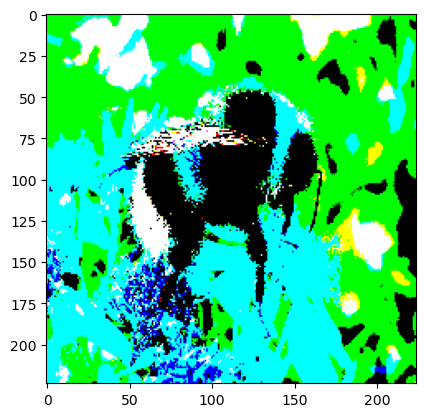

In [153]:
image_cryptarum = transform_img_fn([os.path.join('/home/hduser/Desktop/testing dataset/bombus cryptarum',
                                                 'bombus cryptarum male 19.jpg')], vgg19)
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(image_cryptarum[0] / 2 + 0.5)

preds = model_vgg19.predict(image_cryptarum)
# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

In [ ]:
explanation = explainer.explain_instance(image_cryptarum[0].astype('double'), 
                                         model_vgg19.predict, 
                                         top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 592ms/step


In [ ]:
image_cryptarum = transform_img_fn([os.path.join('/home/hduser/Desktop/testing dataset/bombus bohemicus',
                                                 'bombus bohemicus male 9.jpg')], resnet50)
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(image_bohemicus[0] / 2 + 0.5)

preds = model_resnet50.predict(image_bohemicus)
# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

In [ ]:
image_cryptarum = transform_img_fn([os.path.join('/home/hduser/Desktop/testing dataset/bombus bohemicus',
                                                 'bombus bohemicus male 9.jpg')], resnet50)
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(image_bohemicus[0] / 2 + 0.5)

preds = model_resnet50.predict(image_bohemicus)
# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

- **VGG16**

In [ ]:
image_bohemicus = transform_img_fn([os.path.join('/home/hduser/Desktop/testing dataset/bombus bohemicus',
                                                 'bombus bohemicus male 9.jpg')], resnet50)
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(image_bohemicus[0] / 2 + 0.5)

preds = model_resnet50.predict(image_bohemicus)
# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

In [ ]:
explanation = explainer.explain_instance(image_barbutellus[0].astype('double'), 
                                         model_resnet50.predict, 
                                         top_labels=5, hide_color=0, num_samples=1000)

<br> </br>

In [ ]:
image_bohemicus = transform_img_fn([os.path.join('/home/hduser/Desktop/testing dataset/bombus bohemicus',
                                                 'bombus bohemicus male 9.jpg')], resnet50)
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(image_bohemicus[0] / 2 + 0.5)

preds = model_resnet50.predict(image_bohemicus)
# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

In [ ]:
explanation = explainer.explain_instance(image_barbutellus[0].astype('double'), 
                                         model_resnet50.predict, 
                                         top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
image_cryptarum = transform_img_fn([os.path.join('/home/hduser/Desktop/testing dataset/bombus bohemicus',
                                                 'bombus bohemicus male 9.jpg')], resnet50)
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(image_bohemicus[0] / 2 + 0.5)

preds = model_resnet50.predict(image_bohemicus)
# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

- **MobileNetV2**

In [ ]:
image_bohemicus = transform_img_fn([os.path.join('/home/hduser/Desktop/testing dataset/bombus bohemicus',
                                                 'bombus bohemicus male 9.jpg')], resnet50)
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(image_bohemicus[0] / 2 + 0.5)

preds = model_resnet50.predict(image_bohemicus)
# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

In [ ]:
explanation = explainer.explain_instance(image_barbutellus[0].astype('double'), 
                                         model_resnet50.predict, 
                                         top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
image_cryptarum = transform_img_fn([os.path.join('/home/hduser/Desktop/testing dataset/bombus bohemicus',
                                                 'bombus bohemicus male 9.jpg')], resnet50)
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(image_bohemicus[0] / 2 + 0.5)

preds = model_resnet50.predict(image_bohemicus)
# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

<br> </br>

In [ ]:
image_bohemicus = transform_img_fn([os.path.join('/home/hduser/Desktop/testing dataset/bombus bohemicus',
                                                 'bombus bohemicus male 9.jpg')], resnet50)
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(image_bohemicus[0] / 2 + 0.5)

preds = model_resnet50.predict(image_bohemicus)
# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

In [ ]:
explanation = explainer.explain_instance(image_barbutellus[0].astype('double'), 
                                         model_resnet50.predict, 
                                         top_labels=5, hide_color=0, num_samples=1000)

- **InceptionV3**

In [ ]:
def transform_img_fn_inception(path_list, model):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(img_height_inception, img_width_inception))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = model.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [ ]:
image_cryptarum = transform_img_fn([os.path.join('/home/hduser/Desktop/testing dataset/bombus bohemicus',
                                                 'bombus bohemicus male 9.jpg')], resnet50)
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(image_bohemicus[0] / 2 + 0.5)

preds = model_resnet50.predict(image_bohemicus)
# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

In [ ]:
explanation = explainer.explain_instance(image_barbutellus[0].astype('double'), 
                                         model_resnet50.predict, 
                                         top_labels=5, hide_color=0, num_samples=1000)

<br> </br>

In [ ]:
explanation = explainer.explain_instance(image_barbutellus[0].astype('double'), 
                                         model_resnet50.predict, 
                                         top_labels=5, hide_color=0, num_samples=1000)

- **InceptionResnetV2**

In [ ]:
explanation = explainer.explain_instance(image_barbutellus[0].astype('double'), 
                                         model_resnet50.predict, 
                                         top_labels=5, hide_color=0, num_samples=1000)

<br> </br>

In [ ]:
explanation = explainer.explain_instance(image_barbutellus[0].astype('double'), 
                                         model_resnet50.predict, 
                                         top_labels=5, hide_color=0, num_samples=1000)